# LUT-based Hierarchical Reversible Logic Synthesis (Experimental Results)

This notebook generates Tables 3 and 4 of the experimental evaluation in the paper *LUT-based Hierarchical Reversible Logic Synthesis*.  It extracts the data from the database of computed synthesis results for the EPFL benchmarks.

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from lib.database import Database
from lib.utils import thousand_sep

In [2]:
# configure pandas display format
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# configure matplotlib
matplotlib.rcParams.update({
    'axes.linewidth': 0.4,
    'font.family': 'serif',
    'font.serif': 'times',
    'font.size': 8,
    'hatch.color': 'red',
    'hatch.linewidth': 0.2,
    'legend.edgecolor': 'red',
    'legend.fancybox': False,
    'text.usetex': True,
    'text.color': 'red',
    'xtick.color': 'red',
    'ytick.color': 'red',
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.labelcolor': 'red',
    'axes.edgecolor': 'red',
    'axes.labelsize': 8})

## Benchmarks

As benchmarks we consider all arithmetic instances of the EPFL combinational benchmark suite in two versions.  The first version is the original AIG as provided in the benchmark suite and the second version is the AIG derived from the best-size 6-LUT mapping (version 2017.1).  The latter ones are suffixed using `_bl`.

In [4]:
benchmarks = ["adder", "bar", "div", "hyp", "log2", "max", "multiplier", "sin", "sqrt", "square"]
benchmarks_bl = ["{}_bl".format(benchmark) for benchmark in benchmarks]

The following list contains all synthesis approaches and their configurations that were used in the experimental evaluation.

In [5]:
configurations = [
    ("DXS", "dxs", {}),
    ("CBS", "cbs", {"threshold": 10}),
    ("BDD", "hdbs", {}),
    ("LHRS-6-direct-def", "lhrs", {"esopcovermethod": "bdd", "mapping_strategy": "direct", "esopscript": "def", "cut_size": 6, "class_method": 1}),
    ("LHRS-6-mindb-def", "lhrs", {"esopcovermethod": "bdd", "mapping_strategy": "min_db", "esopscript": "def", "cut_size": 6, "class_method": 1}),
    ("LHRS-6-direct-def_wo4", "lhrs", {"esopcovermethod": "bdd", "mapping_strategy": "direct", "esopscript": "def_wo4", "cut_size": 6, "class_method": 1}),
    ("LHRS-6-mindb-def_wo4", "lhrs", {"esopcovermethod": "bdd", "mapping_strategy": "min_db", "esopscript": "def_wo4", "cut_size": 6, "class_method": 1}),
    ("LHRS-10-direct-def", "lhrs", {"esopcovermethod": "bdd", "mapping_strategy": "direct", "esopscript": "def", "cut_size": 10, "class_method": 1}),
    ("LHRS-10-mindb-def", "lhrs", {"esopcovermethod": "bdd", "mapping_strategy": "min_db", "esopscript": "def", "cut_size": 10, "class_method": 1}),
    ("LHRS-10-direct-def_wo4", "lhrs", {"esopcovermethod": "bdd", "mapping_strategy": "direct", "esopscript": "def_wo4", "cut_size": 10, "class_method": 1}),
    ("LHRS-10-mindb-def_wo4", "lhrs", {"esopcovermethod": "bdd", "mapping_strategy": "min_db", "esopscript": "def_wo4", "cut_size": 10, "class_method": 1}),
    ("LHRS-16-direct-def", "lhrs", {"esopcovermethod": "bdd", "mapping_strategy": "direct", "esopscript": "def", "cut_size": 16, "class_method": 1}),
    ("LHRS-16-mindb-def", "lhrs", {"esopcovermethod": "bdd", "mapping_strategy": "min_db", "esopscript": "def", "cut_size": 16, "class_method": 1}),
    ("LHRS-16-direct-def_wo4", "lhrs", {"esopcovermethod": "bdd", "mapping_strategy": "direct", "esopscript": "def_wo4", "cut_size": 16, "class_method": 1}),
    ("LHRS-16-mindb-def_wo4", "lhrs", {"esopcovermethod": "bdd", "mapping_strategy": "min_db", "esopscript": "def_wo4", "cut_size": 16, "class_method": 1})    
]
configurations_dict = dict((l[0], l) for l in configurations)

In [6]:
db = Database()

## Evaluationg the Effect of Parameters

The following code generates Table 3 of the paper.

In [7]:
index = pd.MultiIndex.from_product([benchmarks, [6, 10, 16], ["Best-LUT", "Original"]], names=['Benchmark', 'LUT size', 'Design'])
columns = pd.MultiIndex(levels=[["", "direct", "hybrid"], ["", "def", "def_wo4"], ["Qubits", "T-count", "Time"]], labels=[[0, 1, 1, 1, 1, 2, 2, 2, 2], [0, 1, 1, 2, 2, 1, 1, 2, 2], [0, 1, 2, 1, 2, 1, 2, 1, 2]], names=["Mapping", "Script", "Metric"])

table = pd.DataFrame(index = index, columns = columns)

col_combinations = list(itertools.product(["direct", "mindb"], ["def", "def_wo4"]))
row_combinations = list(itertools.product([6, 10, 16], [benchmarks_bl, benchmarks]))

for i, (mapping_strategy, esopscript) in enumerate(col_combinations):
    conf_pattern = "LHRS-{{}}-{}-{}".format(mapping_strategy, esopscript)

    get_stats = lambda benchmarks, configuration: list(zip(*db.get_main_statistics(benchmarks, "lhrs", configurations_dict[configuration][2])))

    stats = [get_stats(benchmarks, conf_pattern.format(cut_size)) for cut_size, benchmarks in row_combinations]

    qubits = [s[0] for s in stats]
    tcount = [s[1] for s in stats]
    runtime = [s[2] for s in stats]
    
    if i == 0:
        table.iloc[:,0] = list(sum(zip(*qubits), ()))
    table.iloc[:,i * 2 + 1] = list(sum(zip(*tcount), ()))
    table.iloc[:,i * 2 + 2] = list(sum(zip(*runtime), ()))

table.style.format(thousand_sep)

## Comparison to State-of-the-Art Algorithms

The following code generates Table 4 of the paper.

In [8]:
columns = pd.MultiIndex.from_product([["CBS", "DXS", "BDD", "LHRS-6", "LHRS-10", "LHRS-16"], ["Qubits", "T-count", "Time"]], names=["Approach", "Metric"])

table = pd.DataFrame(index = benchmarks + benchmarks_bl, columns = columns)

for i, key in enumerate(["CBS", "DXS", "BDD", "LHRS-6-mindb-def_wo4", "LHRS-10-mindb-def_wo4", "LHRS-16-mindb-def_wo4"]):
    configuration = configurations_dict[key]
    qubits, tcount, runtime = zip(*db.get_main_statistics(benchmarks + benchmarks_bl, configuration[1], configuration[2]))
    
    table.iloc[:,3 * i] = qubits
    table.iloc[:,3 * i + 1] = tcount
    table.iloc[:,3 * i + 2] = runtime

table

Approach          CBS                         DXS                     BDD  \
Metric         Qubits    T-count     Time  Qubits  T-count   Time  Qubits   
adder             640     427896     5.01     386     1785   0.01    None   
bar               935    1646314    36.14    1359    36036   0.10    None   
div             28567   36344794   735.28   21166   468489  19.43    None   
hyp             91272  152597174  3429.19  125433  1113392 762.55    None   
log2             8811   22029122   471.89   21625   245868  13.69    None   
max              1157    2873590    89.65    2493    23268   0.38    None   
multiplier       5548    6771882   122.55   15691   159271   7.67    None   
sin              1714    4041028    99.58    3818    43778   0.46  890414   
sqrt             6778   28627150   412.80   17485   215068   9.82    None   
square           6479    9837268   207.44   12091   130445   4.64    None   
adder_bl         1023    1973318    43.77     701     6692   0.04    None   
bar_bl            748     616754    10.36    1737    11648   0.11    None   
div_bl          12215   58064206  2461.32   15411   158774  14.16    None   
hyp_bl         141505  661691082 20165.43  141410  1363614 827.20    None   
log2_bl         15739   55549274  1789.86   29461   357553  28.29    None   
max_bl            994    2846164    46.07    1611    10920   0.18    None   
multiplier_bl   13105   44389136  1213.33   18967   223398  11.80    None   
sin_bl           2929   10503022   316.16    5807    72037   0.99  890414   
sqrt_bl         12000   65083062  2584.43   15672   160566   7.18    None   
square_bl       12348   44222254  1226.92   10584   118272   3.59    None   

Approach                        LHRS-6                 LHRS-10            \
Metric          T-count    Time Qubits  T-count   Time  Qubits   T-count   
adder              None    None    505     1988   0.05     490      2730   
bar                None    None    584   108917   0.95     584    108917   
div                None    None  12389   729940  11.40   12055    874476   
hyp                None    None  47814  3021920 174.50   43871   4330883   
log2               None    None   7611   628777   5.04    2875  15188782   
max                None    None   1233    48490   1.60     901     55993   
multiplier         None    None   5806   399632   7.87    3105   1035633   
sin            37920330 2998.05   1468   109248   5.25     714    661028   
sqrt               None    None   8212   712757   2.00    7892    758762   
square             None    None   4058   504369   3.58    3355    781512   
adder_bl           None    None    448    21023   0.43     445     21953   
bar_bl             None    None    840    17024   0.05     740     25676   
div_bl             None    None   3399   405896   3.31    3226    466635   
hyp_bl             None    None  40611  6495823 371.59   36444   8789664   
log2_bl            None    None   6627   860028  20.35    3038  14116708   
max_bl             None    None   1036    18369   1.30     840     23460   
multiplier_bl      None    None   5048   929110   5.81    3418   1288912   
sin_bl         37920330 3207.84   1277   195203   7.84     558    603866   
sqrt_bl            None    None   3204   407081   6.54    2874    508105   
square_bl          None    None   3309   651639   5.53    2882    911949   

Approach             LHRS-16                   
Metric          Time  Qubits   T-count   Time  
adder           0.05     463      4914   0.10  
bar             0.96     582    110669   0.82  
div             6.72   11827   1044271   6.94  
hyp           217.42   39324   6194774 325.07  
log2           91.37    2315  41207475 587.85  
max             0.63     796     63993   1.31  
multiplier     10.48    2852   1299740  11.11  
sin             6.51     518   1938452  11.96  
sqrt            1.58    7816    861567   2.04  
square          4.39    2664   1898077 219.48  
adder_bl        0.46     443     23273   0.64  
bar_bl  

## Distribution of AN-classes

The following code generates Fig. 9 of the paper.

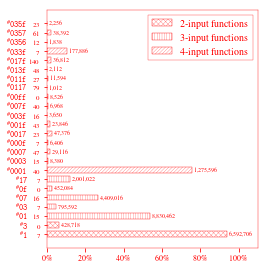

In [9]:
%matplotlib inline

counters = [db.get_class_counters(configuration) for _, method, configuration in configurations if method == 'lhrs']
sums = [sum(l) for l in zip(*counters)][0:3]
sums = [x[1:] for x in sums]
sumsp = [(x / np.sum(x)) for x in sums]

tcounts = [[7, 0], [15, 7, 16, 0, 7], [40, 15, 47, 7, 23, 43, 16, 40, 0, 79, 27, 48, 140, 7, 12, 61, 23]]
classes = [[0x1, 0x3], [0x01, 0x03, 0x07, 0x0f, 0x17], [0x0001, 0x0003, 0x0007, 0x000f, 0x0017, 0x001f, 0x003f, 0x007f, 0x00ff, 0x0117, 0x011f, 0x013f, 0x017f, 0x033f, 0x0356, 0x0357, 0x035f]]
ylabels = []

hatches = ['xxxxx', '|||||', '///////']
fig, ax = plt.subplots()
fig.subplots_adjust(left=.16, bottom=0.055, right=.999, top=0.999)
b = 0
for i, w in enumerate(sumsp):
    p = ax.barh(y = range(b, b + len(w)), width = [x * 100 for x in w], hatch = hatches[i], height = 0.6, fill = False, linewidth = .4, edgecolor = 'red')
    for j, r in enumerate(p.patches):
        ax.text(r.get_x() + r.get_width() + 1, r.get_y() + r.get_height() / 2, '%s' % thousand_sep( int( sums[i][j] ) ), ha = 'left', va = 'center', fontsize = 6)
    b += len(w)
    fmt = '$^{\\mathrm{\\#}}$\\texttt{%0' + str(2**i) + 'x} {\\scriptsize %s%d}'
    ylabels += [fmt % (c, '\\phantom{0}' * (3 - len(str(t))), t) for (c, t) in zip(classes[i], tcounts[i])]
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d\%%'))
ax.set_xlim([0, 110])
ax.set_yticks(range(b))
ax.set_yticklabels(ylabels)
l = ax.legend(handles = [patches.Patch(hatch = style, edgecolor = 'red', facecolor = 'white', linewidth = 0.4, linestyle = '-', label = '%d-input functions' % (i + 2)) for i, style in enumerate(hatches)])
l.legendPatch.set_linewidth(0.4)

fig.set_size_inches(3.487, 3.5)
fig.savefig('classes.pdf')